In [34]:
# Importer les bibliothèques nécessaires

# Pour manipuler les bases de données et les graphes
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Pour le ML
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold

In [26]:
# Charger le jeu de données
path = "/home/onyxia/work/statapp_sujet26/"
#enlever work si nécessaire
file_name1 = "dataset_complet_part_1.csv"
file_name2 = "dataset_complet_part_2.csv"
df1 = pd.read_csv(path+file_name1, sep=',',low_memory=False)
df2 = pd.read_csv(path+file_name2, sep=',',low_memory=False)
df = pd.concat([df1,df2])

df = df.loc[df['an'] == 2019]
df['grav'] = df['grav'].replace({1:0,2:0,3:1,4:1})

df = df.drop(columns=['Num_Acc','an','adr','lat','long','lartpc','larrout','com','gps','voie','dep','v2','pr','pr1'])
#ici on enlève an car on ne regarde que pour 2019
df['hrmn'] = df['hrmn'].str.split(':').str[0].astype(int)
df['nbv'] = df['nbv'].astype(int)

df.to_csv('XGboost.csv', index=False)

y = df['grav']
X = df.drop(columns=['grav'])
features = X.columns

In [36]:
# Charger le jeu de données
path = "/home/onyxia/work/statapp_sujet26/"
#enlever work si nécessaire
file_name1 = "dataset_complet_avec_dummies_part_1.csv"
file_name2 = "dataset_complet_avec_dummies_part_2.csv"
file_name3 = "dataset_complet_avec_dummies_part_3.csv"
file_name4 = "dataset_complet_avec_dummies_part_4.csv"
df1 = pd.read_csv(path+file_name1, sep=',',low_memory=False)
df2 = pd.read_csv(path+file_name2, sep=',',low_memory=False)
df3 = pd.read_csv(path+file_name2, sep=',',low_memory=False)
df4 = pd.read_csv(path+file_name2, sep=',',low_memory=False)
df = pd.concat([df1,df2,df3,df4])

df['grav'] = df['grav'].replace({1:0,2:0,3:1,4:1})

In [37]:
y = df['grav']
X = df.drop(columns=['grav'])
features = X.columns

#print(X.head())
print(y.head())
print(features)

0    0
1    0
2    0
3    0
4    0
Name: grav, dtype: int64
Index(['nbv', 'vma', 'HP_ind', 'jour_Friday', 'jour_Monday', 'jour_Saturday',
       'jour_Sunday', 'jour_Thursday', 'jour_Tuesday', 'jour_Wednesday',
       ...
       'region_Centre-Val de Loire', 'region_Corse', 'region_Grand Est',
       'region_Hauts-de-France', 'region_Normandie',
       'region_Nouvelle-Aquitaine', 'region_Occitanie', 'region_PACA',
       'region_Pays de la Loire', 'region_Île-de-France'],
      dtype='object', length=109)


In [29]:
# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Normaliser les données
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [30]:
# Définir les paramètres du modèle XGBoost
params = {
    'objective': 'binary:logistic',  # Définit l'objectif (classification multi-classe)
    'eval_metric': 'error',  # Métrique d'évaluation
    'max_depth': 3,  # Profondeur maximale de l'arbre
    'eta': 0.1,  # Taux d'apprentissage
    'learning_rate': 0.1,
    'subsample': 0.7,  # Pourcentage d'échantillons utilisés pour former chaque arbre
    'colsample_bytree': 0.7  # Pourcentage de fonctionnalités utilisées pour former chaque arbre
}

# Convertir les données en DMatrix (format requis par XGBoost)
dtrain = xgb.DMatrix(X_train, label=y_train, enable_categorical=True)
dtest = xgb.DMatrix(X_test, label=y_test, enable_categorical=True)

In [31]:
# Définir les paramètres à rechercher
param_grid = {
    'max_depth': [3, 10, 20],
    'learning_rate': [0.1, 0.01, 0.05],
    'subsample': [0.7, 0.8, 0.9]
}

# Créer un modèle XGBoost
xgb_model = xgb.XGBClassifier(objective='binary:logistic')

# Créer une instance de GridSearchCV
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, scoring='accuracy')

# Effectuer la recherche sur grille sur les données d'entraînement
grid_search.fit(X_train, y_train)

# Afficher les meilleurs paramètres et le meilleur score
print("Meilleurs paramètres trouvés : ", grid_search.best_params_)
print("Meilleur score : ", grid_search.best_score_)

Meilleurs paramètres trouvés :  {'learning_rate': 0.1, 'max_depth': 20, 'subsample': 0.9}
Meilleur score :  0.8789512980576832


In [32]:
params = grid_search.best_params_

# Entraîner le modèle XGBoost
num_round = 100  # Nombre d'itérations d'entraînement
model = xgb.train(params, dtrain, num_round)

# Convertir les prédictions en classes (0 ou 1)
predictions = model.predict(dtest)

# Calculer la précision du modèle
accuracy = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy)

# Afficher le rapport de classification
print("Classification Report:")
print(classification_report(y_test, predictions))

Accuracy: 0.9055914343983684
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.93      0.93      7606
           1       0.88      0.85      0.86      4162

    accuracy                           0.91     11768
   macro avg       0.90      0.89      0.90     11768
weighted avg       0.91      0.91      0.91     11768



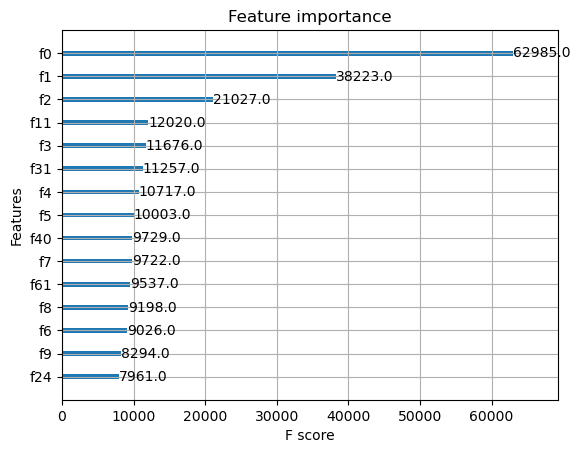

In [33]:
xgb.plot_importance(model, max_num_features=15)
plt.show()

In [39]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold

# Définir une grille de paramètres à rechercher
param_grid = {
    'max_depth': [3, 6, 9],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'n_estimators': [50, 100, 200],
}

# Initialiser le modèle XGBoost
model = xgb.XGBClassifier(objective='binary:logistic', random_state=42)

# Initialiser StratifiedKFold
k_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialiser GridSearchCV avec le modèle, la grille de paramètres et StratifiedKFold
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=k_fold, scoring='accuracy')

# Exécuter la recherche sur la grille
grid_search.fit(X, y)

# Afficher les meilleurs paramètres et le meilleur score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)


Best Parameters: {'colsample_bytree': 0.8, 'max_depth': 9, 'n_estimators': 200, 'subsample': 0.9}
Best Score: 0.8731475186947655


In [44]:
from skopt import BayesSearchCV
from sklearn.model_selection import StratifiedKFold

# Définir une grille de paramètres à rechercher
param_space = {
    'max_depth': (3, 10),
    'subsample': (0.7, 0.9),
    'colsample_bytree': (0.7, 0.9),
    'n_estimators': (50, 200),
}

# Initialiser le modèle XGBoost
model = xgb.XGBClassifier(objective='binary:logistic', random_state=42)

# Initialiser StratifiedKFold
k_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialiser BayesSearchCV avec le modèle, l'espace de recherche de paramètres et StratifiedKFold
bayes_search = BayesSearchCV(estimator=model, search_spaces=param_space, cv=k_fold, scoring='f1', n_jobs=-1, verbose=3)

# Exécuter la recherche bayésienne
bayes_search.fit(X, y)

# Afficher les meilleurs paramètres et le meilleur score
print("Best Parameters:", bayes_search.best_params_)
print("Best Score:", bayes_search.best_score_)


Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 2/5] END colsample_bytree=0.7091850713093302, max_depth=4, n_estimators=133, subsample=0.8799351333835231;, score=0.628 total time=   1.9s
[CV 1/5] END colsample_bytree=0.7091850713093302, max_depth=4, n_estimators=133, subsample=0.8799351333835231;, score=0.617 total time=   1.9s
[CV 4/5] END colsample_bytree=0.7091850713093302, max_depth=4, n_estimators=133, subsample=0.8799351333835231;, score=0.624 total time=   1.9s
[CV 3/5] END colsample_bytree=0.7091850713093302, max_depth=4, n_estimators=133, subsample=0.8799351333835231;, score=0.631 total time=   2.0s
[CV 5/5] END colsample_bytree=0.7091850713093302, max_depth=4, n_estimators=133, subsample=0.8799351333835231;, score=0.640 total time=   2.0s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 2/5] END colsample_bytree=0.8404124576489005, max_depth=4, n_estimators=151, subsample=0.7255089573955724;, score=0.632 total time=   1.6s
[CV 3/5] END colsample_b

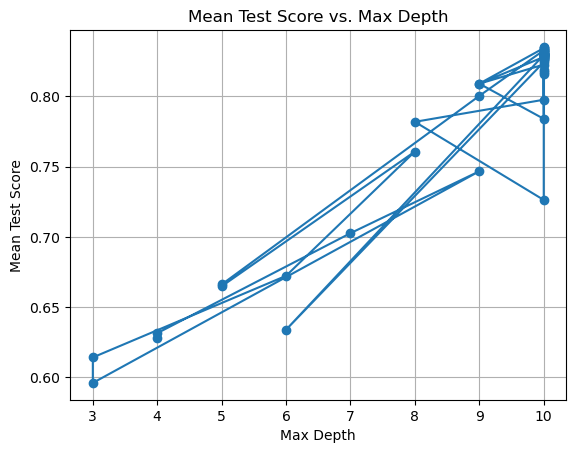

In [45]:
import matplotlib.pyplot as plt

# Extraire les résultats de la recherche
results = bayes_search.cv_results_

# Extraire les valeurs de la profondeur maximale de l'arbre et les scores correspondants
max_depths = results['param_max_depth'].data
mean_scores = results['mean_test_score']

# Tracer le score moyen en fonction de la profondeur maximale de l'arbre
plt.plot(max_depths, mean_scores, marker='o')
plt.xlabel('Max Depth')
plt.ylabel('Mean Test Score')
plt.title('Mean Test Score vs. Max Depth')
plt.grid(True)
plt.show()
